In [9]:
""" BORING!!! """
import numpy as np
import pyreadstat as prs
import sys
sys.path.append('../src')
from clean_data_1 import transform_dataframe_1
from clean_data_2 import transform_dataframe_2
from make_belief_network import make_belief_network
from calc_stress import stress
from interpret_belief_vector import interpret_belief_vector

In [2]:
### Making a belief network ###

""" First we need data """

raw_df, meta = prs.read_sas7bdat("data\gss7222_r3.sas7bdat")

""" Now we need to clean the data """
 
df, metadata = transform_dataframe_1(raw_df)    # df contains all our data, metadata contains some other random shit 


In [10]:
# save all columns as csv
list_of_col = raw_df.columns.tolist

df.to_csv('testset.csv', index=False)



In [49]:
""" Now we specify a time-frame and a set of variables, and make a belief network """

variables = ["PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST"]

start_year = 2000
timeframe = list(range(start_year, start_year+4))

BN, variables_list, correlation_matrix_partial = make_belief_network(df, variables, timeframe, method="spearman", is_partial=True, threshold=0.1, sample_threshold=0, regularisation=0.2)


In [20]:
""" We now have a belief network, a list of variables that made the cut, and the adjacency matrix of partial correlations. """

print(BN)
print(variables_list)
print(correlation_matrix_partial[0,0:5])

Graph with 61 nodes and 74 edges
['PARTYID', 'POLVIEWS', 'NATSPAC', 'NATENVIR', 'NATHEAL', 'NATCITY', 'NATCRIME', 'NATDRUG', 'NATEDUC', 'NATRACE', 'NATARMS', 'NATAID', 'NATFARE', 'NATROAD', 'NATSOC', 'NATMASS', 'NATPARK', 'NATCHLD', 'NATSCI', 'EQWLTH', 'SPKATH', 'COLATH', 'LIBATH', 'SPKRAC', 'COLRAC', 'LIBRAC', 'SPKCOM', 'COLCOM', 'LIBCOM', 'SPKMIL', 'COLMIL', 'LIBMIL', 'SPKHOMO', 'COLHOMO', 'LIBHOMO', 'CAPPUN', 'GUNLAW', 'COURTS', 'GRASS', 'ATTEND', 'RELITEN', 'POSTLIFE', 'PRAYER', 'AFFRMACT', 'WRKWAYUP', 'HELPFUL', 'FAIR', 'TRUST', 'CONFINAN', 'CONBUS', 'CONCLERG', 'CONEDUC', 'CONFED', 'CONLABOR', 'CONPRESS', 'CONMEDIC', 'CONTV', 'CONJUDGE', 'CONSCI', 'CONLEGIS', 'CONARMY', 'GETAHEAD', 'FEPOL', 'ABDEFECT', 'ABNOMORE', 'ABHLTH', 'ABPOOR', 'ABRAPE', 'ABSINGLE', 'ABANY', 'SEXEDUC', 'DIVLAW', 'PREMARSX', 'TEENSEX', 'XMARSEX', 'HOMOSEX', 'PORNLAW', 'SPANKING', 'LETDIE1', 'SUICIDE1', 'SUICIDE2', 'POLHITOK', 'POLABUSE', 'POLMURDR', 'POLESCAP', 'POLATTAK', 'NEWS', 'TVHOURS', 'FECHLD', 'FEPRE

In [50]:
""" In order to calculate the stress of beleif vectors, we need to belief vectors """
""" We first clear the dataset again to implement the median solution """

df_b_vecs, _ = transform_dataframe_2(df, timeframe)

""" We can then cut the data down to only the variables in the belief network """

df_b_vecs = df_b_vecs[variables_list]

""" And then get an array of the belief vectors """

belief_vectors = df_b_vecs.to_numpy()

""" Finally we want to set the NaNs to zero, and normalise the vectors such that they span -1 and 1 """
belief_vectors[np.isnan(belief_vectors)] = 0
belief_vectors = 2*(belief_vectors - np.min(belief_vectors, axis=0))/(np.max(belief_vectors, axis=0) - np.min(belief_vectors, axis=0)) - 1



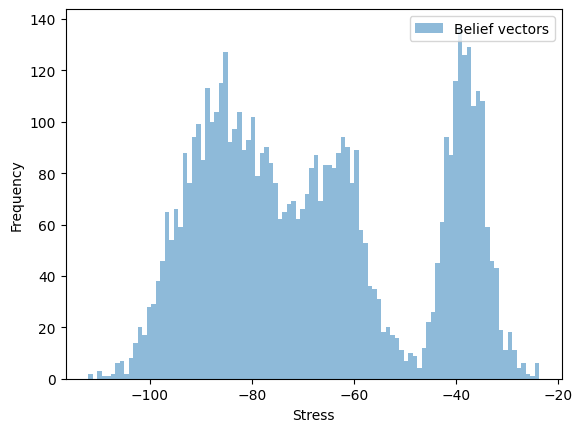

In [53]:
""" Okay, and now we calculate the stress of the belief vectors """

correlation_matrix_noDiag = correlation_matrix_partial - np.eye(correlation_matrix_partial.shape[0])
stress_vec = []
stress_vec = [stress(belief_vectors[i,:], correlation_matrix_partial) for i in range(belief_vectors.shape[0])]

""" We can also compare it to a random set of belief vectors """

# Generate K random belief vectors
# random_belief_vectors = np.random.choice([-1, 0, 1], size=(len(stress_vec), len(variables_list)))
alt_belief_vectors = np.random.rand(len(stress_vec), len(variables_list))*2 - 1
# alt_stress_vec = [stress(vector, correlation_matrix_partial) for vector in random_belief_vectors]

""" We can also compare the stress vectors of republican and democrat belief vectors """

from triads import count_triads
print(count_triads(correlation_matrix_partial))

import matplotlib.pyplot as plt
plt.hist(stress_vec, bins=100, alpha=0.5, label='Belief vectors')
# plt.hist(alt_stress_vec, bins=100, alpha=0.5, label='Random belief vectors')
plt.legend(loc='upper right')
plt.xlabel('Stress')
plt.ylabel('Frequency')
plt.show()

In [55]:
""" Now we can print out the belief vectors in an interpretable way """

""" We can look at the least stressed belief vector """
index = np.argmin(stress_vec)
print("Least stressed belief vector: ")
print(stress(belief_vectors[index], correlation_matrix_partial))
print(interpret_belief_vector(belief_vectors[index], variables_list))

""" And the most stressed belief vector """
index = np.argmax(stress_vec)
print("Most stressed belief vector: ")
print(stress(belief_vectors[index], correlation_matrix_partial))
print(interpret_belief_vector(belief_vectors[index], variables_list))

""" And a median stressed belief vector """
index = np.argsort(stress_vec)[len(stress_vec)//2]
print("Median stressed belief vector: ")
print(stress(belief_vectors[index], correlation_matrix_partial))
print(interpret_belief_vector(belief_vectors[index], variables_list))






Least stressed belief vector: 
-112.10088206103595
PARTYID = 1.0. Leans towards the Republican party.
POLVIEWS = 1.0. Is conservative.
NATSPAC = 1.0. Believes the government is spending too little on the space exploration program.
NATENVIR = 1.0. Believes the government is spending too much on improving and protecting the environment.
NATHEAL = -1.0. Believes the government is spending too little on improving and protecting the nation's health.
NATCITY = 1.0. Believes the government is spending too much on solving the problems of big cities.
NATCRIME = -1.0. Believes the government is spending too little on halting the rising crime rate.
NATDRUG = 1.0. Believes the government is spending too much on dealing with drug addiction.
NATEDUC = -1.0. Believes the government is spending too little on improving the nation's education system.
NATRACE = 1.0. Believes the government is spending too much on improving the conditions of Blacks.
NATARMS = -1.0. Believes the government is spending too 

(364, 0)
